# EC6011: Business Forecasting

# Introduction

The forecasting aims to delve into the realm of international finance, exploring the core concepts on nominal and real exchange and the validity of Purchasing Power Parity (PPP). In this project, we have selected two distinct countries such as Canada as a home country and Australia as a foreign country and analysing their economic data over 10 year period, we aim to investigate the relationship between real exchange rate and their price levels. In this forecasting analysis, we aim to involve applications such as econometric modelling, examine absolute and relative forms of Purchase Power Parity, testing whether they hold true for the chosen home and foreign country. Furthermore, we will employ Box-Jenkins models and forecast the real exchange rate, providing insights into its dynamic behaviour.

# Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima_process import ArmaProcess

from tabulate import tabulate

# Importing the dataset

In [2]:
forecasting = pd.read_excel(r"/Users/purandarakashyap/Documents/UCC/Semester - 2/EC6011 - Business Forecasting/EC6011_final_data.xlsx")
forecasting.head()

,Quarter,CPI_Canada,CPI_australia,Nominal exchange rate,Real exchange rate
0,Q1 2014,124.000000,105.4,1.012666,0.860766
1,Q2 2014,125.633333,105.9,0.981599,0.827418
2,Q3 2014,125.733333,106.4,0.993251,0.840524
3,Q4 2014,125.266667,106.6,1.029473,0.876066
4,Q1 2015,125.333333,106.8,1.024530,0.873031


# Initital data exploration:

In [3]:
forecasting['Year'] = forecasting['Quarter'].str.extract(r'(\d{4})').astype(int)
forecasting['Quarter_Num'] = forecasting['Quarter'].str.extract(r'Q(\d)').astype(int)
forecasting['Date'] = pd.to_datetime(forecasting['Year'].astype(str) + '-Q' + forecasting['Quarter_Num'].astype(str))
forecasting = forecasting.drop(columns= ['Quarter', 'Year', 'Quarter_Num'])
forecasting.set_index('Date', inplace= True)

/var/folders/nx/bmvrdfnn1412nr7h8kv9m8500000gn/T/ipykernel_98590/3708295167.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  forecasting['Date'] = pd.to_datetime(forecasting['Year'].astype(str) + '-Q' + forecasting['Quarter_Num'].astype(str))


In [4]:
print(forecasting.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44 entries, 2014-01-01 to 2024-10-01
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CPI_Canada             44 non-null     float64
 1   CPI_australia          44 non-null     float64
 2   Nominal exchange rate  44 non-null     float64
 3   Real exchange rate     44 non-null     float64
dtypes: float64(4)
memory usage: 1.7 KB
None


In [5]:
forecasting.describe().T.style.background_gradient(axis= 0)

,count,mean,std,min,25%,50%,75%,max
CPI_Canada,44.000000,138.878030,12.032011,124.000000,128.783333,136.316667,148.133333,161.666667
CPI_australia,44.000000,118.029545,10.606286,105.400000,109.850000,114.600000,124.450000,139.400000
Nominal exchange rate,44.000000,1.059841,0.045499,0.981599,1.022984,1.054186,1.097275,1.138967
Real exchange rate,44.000000,0.900582,0.040141,0.827418,0.867318,0.894086,0.934841,0.974812


In [6]:
forecasting.isnull().sum()

CPI_Canada               0
CPI_australia            0
Nominal exchange rate    0
Real exchange rate       0
dtype: int64

# Statistical description

# Measures of central tendency

In [7]:
skewness_forecast = round(forecasting['Real exchange rate'].skew(), 2)
kurtosis_forecast = round(forecasting['Real exchange rate'].kurt(), 2)
median_forecast = round(forecasting['Real exchange rate'].median(), 2)
mode_forecast = round(forecasting['Real exchange rate'].mode(),2)

summary_data_central = pd.DataFrame({
    'Metric': ['Skewness', 'Kurtosis', 'Median', 'Mode'],
    'Value': [skewness_forecast, kurtosis_forecast, median_forecast, mode_forecast[0]]})

print("The statistical summary on \"Measures of central tendency\" for the feature: \"Real Exchange Rate\" \n")
print(tabulate(summary_data_central, headers= 'keys', tablefmt= 'pretty'))

The statistical summary on "Measures of central tendency" for the feature: "Real Exchange Rate" 

+---+----------+-------+
|   |  Metric  | Value |
+---+----------+-------+
| 0 | Skewness | 0.24  |
| 1 | Kurtosis | -0.97 |
| 2 |  Median  | 0.89  |
| 3 |   Mode   | 0.83  |
+---+----------+-------+


# Measures of dispersion

In [8]:
variance_forecast = round(forecasting['Real exchange rate'].var(), 2)
range_forecast = round(forecasting['Real exchange rate'].max() - forecasting['Real exchange rate'].min(),2)
stdev_forecast = round(forecasting['Real exchange rate'].std(), 2)

summary_data_dispersion = pd.DataFrame({
    'Metric': ['Standard Deviation', 'Variance', 'Range'],
    'Value': [stdev_forecast, variance_forecast, range_forecast]
})

print("The statistical summary on \"Measures of dispersion\" for the feature: \"Real Exchange Rate\" \n")
print(tabulate(summary_data_dispersion, headers= 'keys', tablefmt= 'pretty'))

The statistical summary on "Measures of dispersion" for the feature: "Real Exchange Rate" 

+---+--------------------+-------+
|   |       Metric       | Value |
+---+--------------------+-------+
| 0 | Standard Deviation | 0.04  |
| 1 |      Variance      |  0.0  |
| 2 |       Range        | 0.15  |
+---+--------------------+-------+


ADF Statistic: -1.560103830738448
p-value: 0.5035974211094394
Critical Values: {'1%': -3.5925042342183704, '5%': -2.931549768951162, '10%': -2.60406594375338}


Differenced data ADF test:
ADF Statistic: -6.766240203497674
p-value: 2.7126301324578836e-09
Critical Values: {'1%': -3.596635636000432, '5%': -2.933297331821618, '10%': -2.6049909750566895}


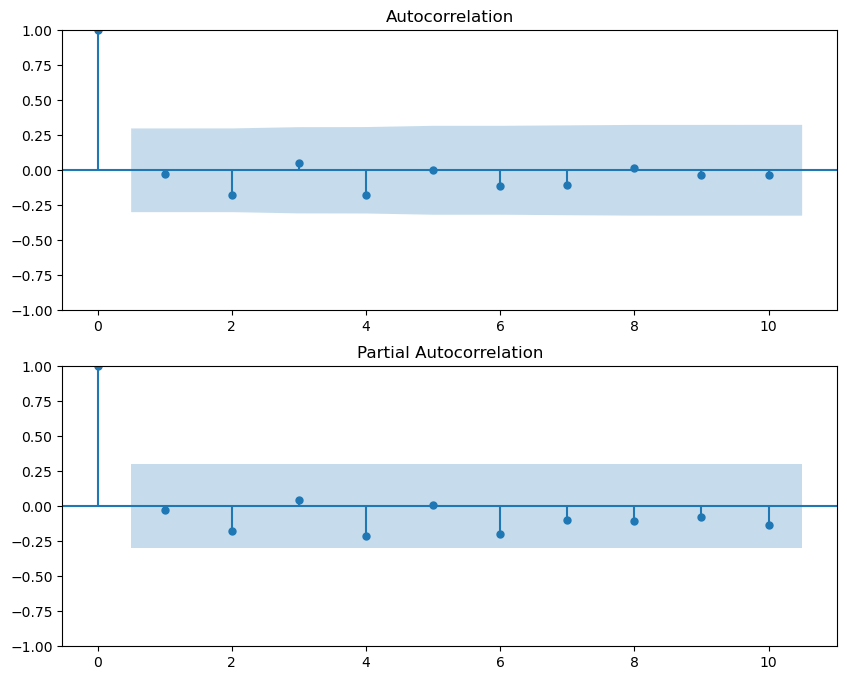

In [9]:
real_exchange_rate = forecasting['Real exchange rate']

adf_test = adfuller(real_exchange_rate)
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:", adf_test[4])
print('\n')

if adf_test[1] > 0.05:
    real_exchange_rate_diff = real_exchange_rate.diff().dropna() 
    print("Differenced data ADF test:")
    adf_test_diff = adfuller(real_exchange_rate_diff)
    print("ADF Statistic:", adf_test_diff[0])
    print("p-value:", adf_test_diff[1])
    print("Critical Values:", adf_test_diff[4])
    real_exchange_rate_for_plots = real_exchange_rate_diff
else:
    real_exchange_rate_for_plots = real_exchange_rate

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(real_exchange_rate_for_plots, ax=axes[0], lags=10)
plot_pacf(real_exchange_rate_for_plots, ax=axes[1], lags=10) 
plt.show()

# Task-1 [Creation of Log] 

In [10]:
forecasting["log_nominal_exchange_rate"] = np.log(forecasting["Nominal exchange rate"])
forecasting["log_real_exchange_rate"] = np.log(forecasting["Real exchange rate"])
forecasting["log_CPI_Canada"] = np.log(forecasting["CPI_Canada"])
forecasting["log_CPI_Australia"] = np.log(forecasting["CPI_australia"])

In [11]:
forecasting.head()

,CPI_Canada,CPI_australia,Nominal exchange rate,Real exchange rate,log_nominal_exchange_rate,log_real_exchange_rate,log_CPI_Canada,log_CPI_Australia
Date,,,,,,,,
2014-01-01,124.000000,105.4,1.012666,0.860766,0.012586,-0.149933,4.820282,4.657763
2014-04-01,125.633333,105.9,0.981599,0.827418,-0.018572,-0.189445,4.833368,4.662495
2014-07-01,125.733333,106.4,0.993251,0.840524,-0.006772,-0.173729,4.834163,4.667206
2014-10-01,125.266667,106.6,1.029473,0.876066,0.029047,-0.132314,4.830445,4.669084
2015-01-01,125.333333,106.8,1.024530,0.873031,0.024234,-0.135785,4.830977,4.670958


In [12]:
forecasting.describe().T.style.background_gradient(axis= 0)

,count,mean,std,min,25%,50%,75%,max
CPI_Canada,44.000000,138.878030,12.032011,124.000000,128.783333,136.316667,148.133333,161.666667
CPI_australia,44.000000,118.029545,10.606286,105.400000,109.850000,114.600000,124.450000,139.400000
Nominal exchange rate,44.000000,1.059841,0.045499,0.981599,1.022984,1.054186,1.097275,1.138967
Real exchange rate,44.000000,0.900582,0.040141,0.827418,0.867318,0.894086,0.934841,0.974812
log_nominal_exchange_rate,44.000000,0.057219,0.042913,-0.018572,0.022724,0.052768,0.092830,0.130121
log_real_exchange_rate,44.000000,-0.105680,0.044414,-0.189445,-0.142349,-0.111953,-0.067387,-0.025511
log_CPI_Canada,44.000000,4.930045,0.084576,4.820282,4.858131,4.914981,4.998026,5.085537
log_CPI_Australia,44.000000,4.767145,0.087194,4.657763,4.699113,4.741446,4.823875,4.937347


# Task-2 [Analysing the forecast data properties]

# Time series plot

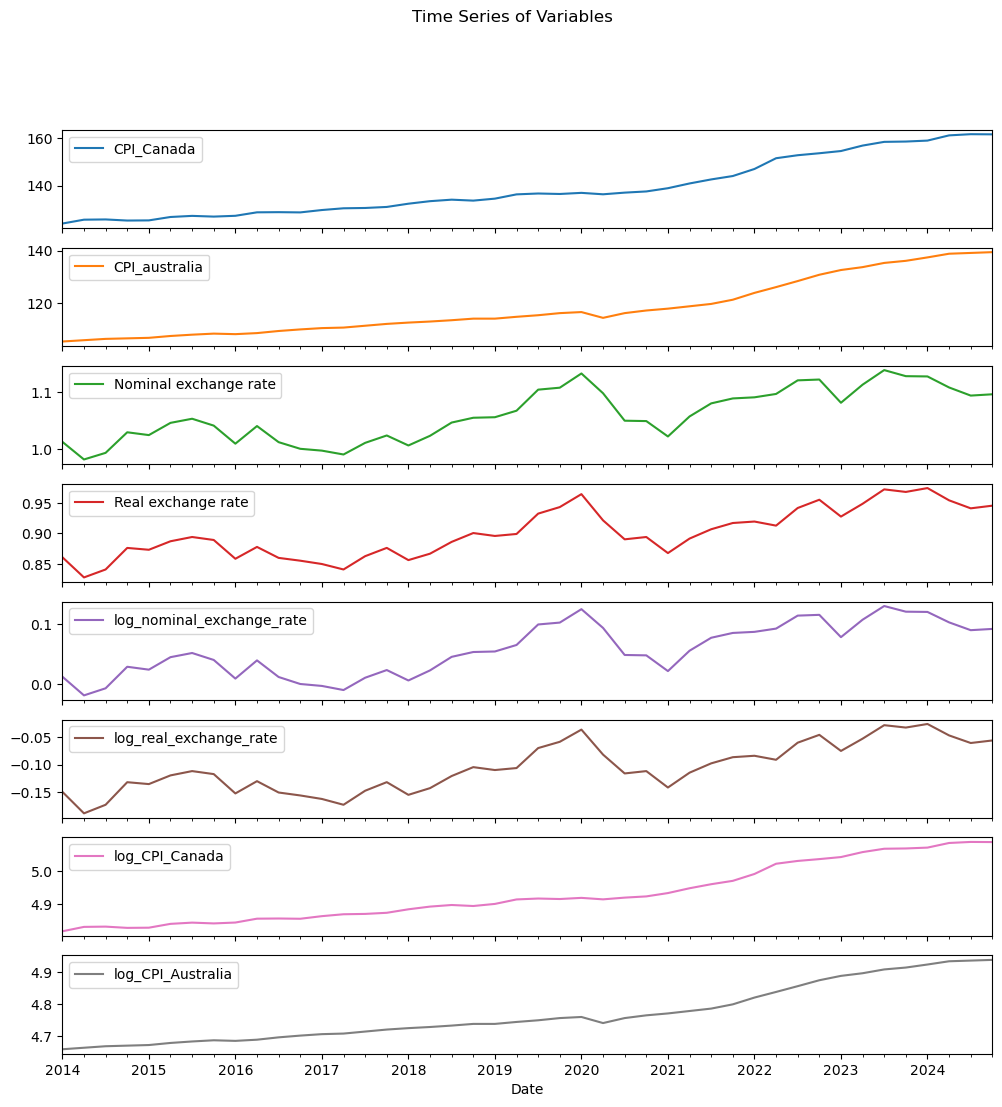

In [13]:
forecasting.plot(subplots= True, figsize=(12, 12), title= "Time Series of Variables")
plt.show()

# Correlation Matrix

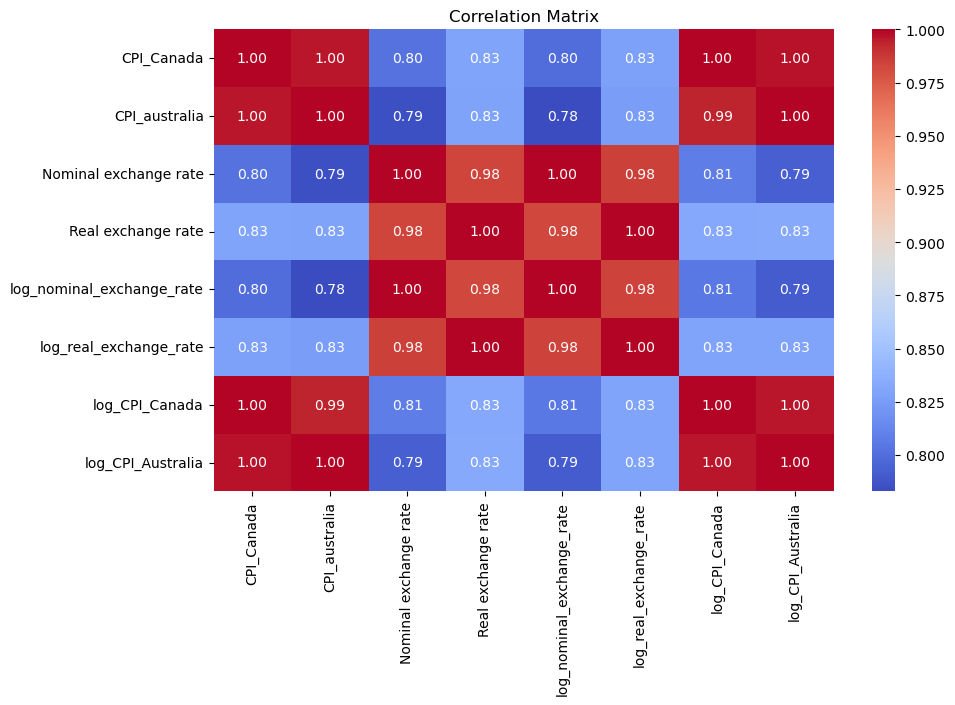

In [14]:
plt.figure(figsize=(10, 6))
sns.heatmap(forecasting.corr(), annot= True, cmap= "coolwarm", fmt= ".2f")
plt.title("Correlation Matrix")
plt.show()

# Stationarity check [Augmented Dickey-Fuller (ADF) test]

In [15]:
def adf_test(series):
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Critical Values:", result[4])
    if result[1] < 0.05:
        print("Conclusion: Stationary")
    else:
        print("Conclusion: Not Stationary")

for column in forecasting.columns:
    print(f"\nADF Test for {column}:")
    adf_test(forecasting[column])


ADF Test for CPI_Canada:
ADF Statistic: 3.1422
p-value: 1.0000
Critical Values: {'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}
Conclusion: Not Stationary

ADF Test for CPI_australia:
ADF Statistic: 1.4196
p-value: 0.9972
Critical Values: {'1%': -3.596635636000432, '5%': -2.933297331821618, '10%': -2.6049909750566895}
Conclusion: Not Stationary

ADF Test for Nominal exchange rate:
ADF Statistic: -1.6774
p-value: 0.4428
Critical Values: {'1%': -3.5925042342183704, '5%': -2.931549768951162, '10%': -2.60406594375338}
Conclusion: Not Stationary

ADF Test for Real exchange rate:
ADF Statistic: -1.5601
p-value: 0.5036
Critical Values: {'1%': -3.5925042342183704, '5%': -2.931549768951162, '10%': -2.60406594375338}
Conclusion: Not Stationary

ADF Test for log_nominal_exchange_rate:
ADF Statistic: -1.6787
p-value: 0.4421
Critical Values: {'1%': -3.5925042342183704, '5%': -2.931549768951162, '10%': -2.60406594375338}
Conclusion: Not Stationary

ADF Test for log

# Stationarity check of the trend analysis

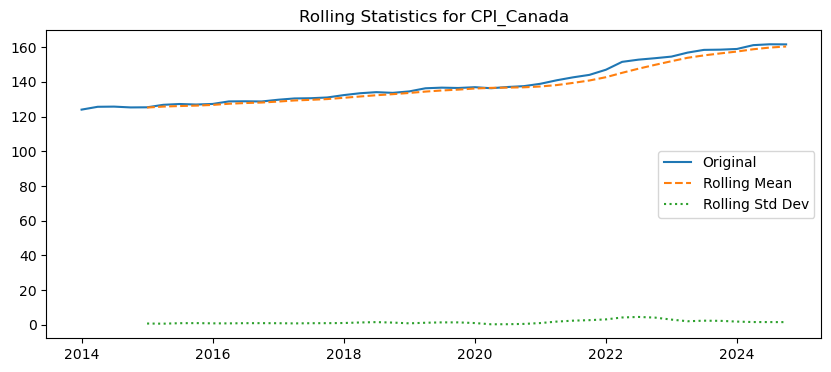

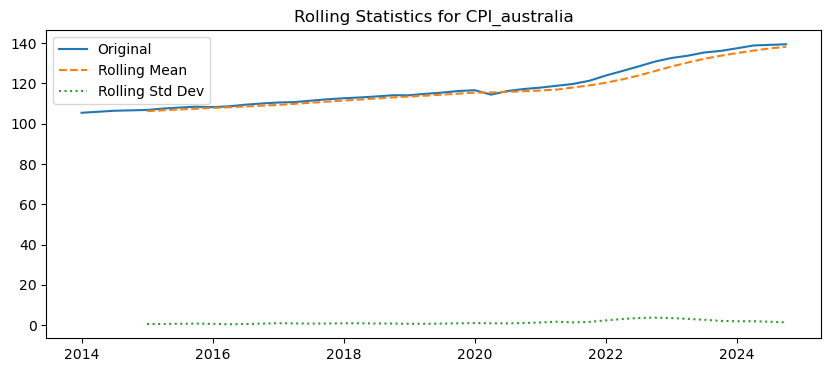

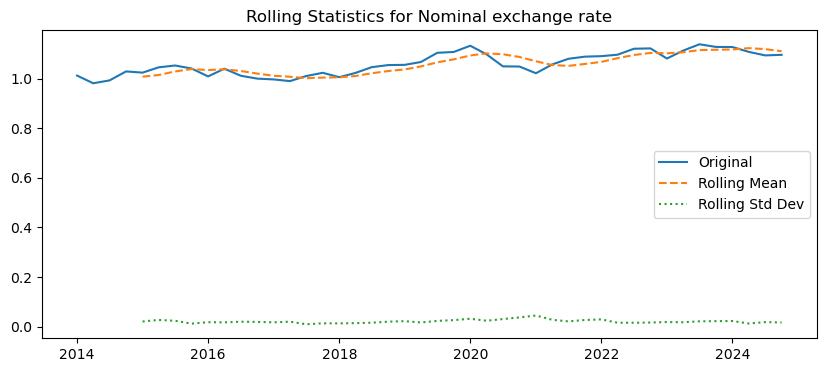

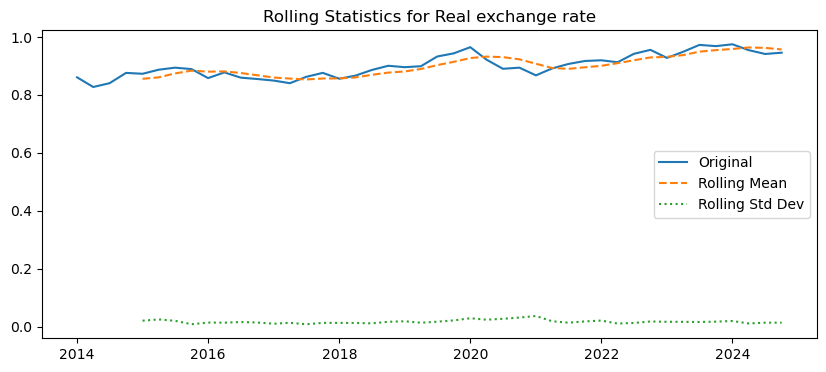

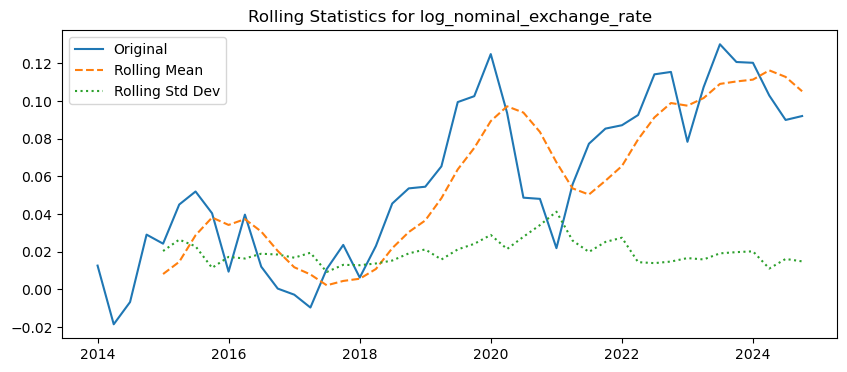

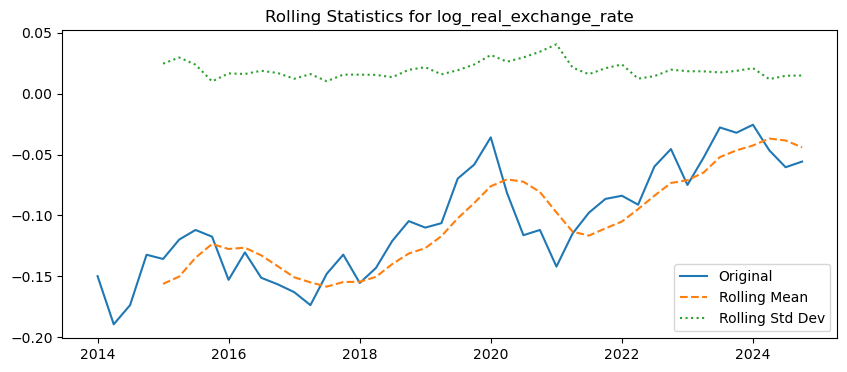

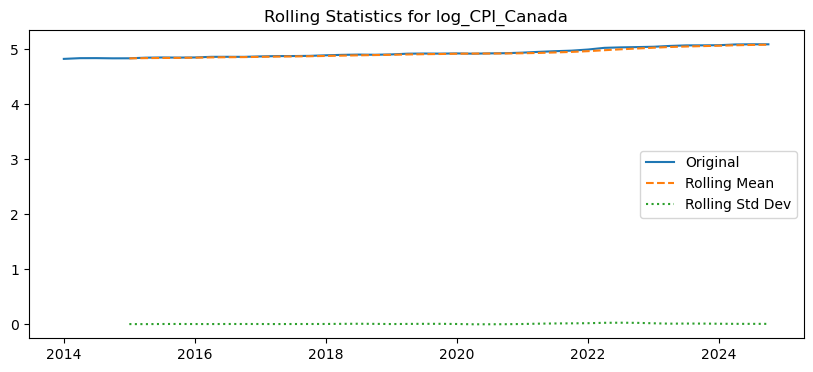

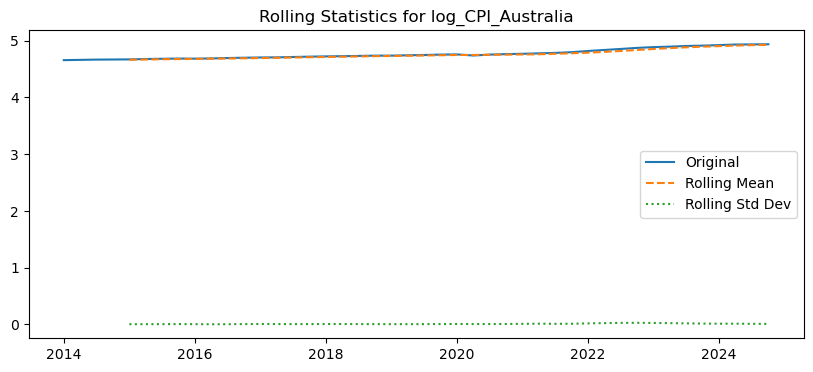

In [16]:
window = 5  
for column in forecasting.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(forecasting[column], label= 'Original')
    plt.plot(forecasting[column].rolling(window= window).mean(), label= 'Rolling Mean', linestyle= 'dashed')
    plt.plot(forecasting[column].rolling(window= window).std(), label= 'Rolling Std Dev', linestyle= 'dotted')
    plt.title(f"Rolling Statistics for {column}")
    plt.legend()
    plt.show()

# First order differencing [Re-run ADF test]

In [17]:
forecasting_diff = forecasting.diff().dropna()

print("After First Differencing:\n")
for column in forecasting_diff.columns:
    print(f"\nADF Test for {column} (Differenced):")
    adf_test(forecasting_diff[column])

After First Differencing:


ADF Test for CPI_Canada (Differenced):
ADF Statistic: -2.2916
p-value: 0.1747
Critical Values: {'1%': -3.6055648906249997, '5%': -2.937069375, '10%': -2.606985625}
Conclusion: Not Stationary

ADF Test for CPI_australia (Differenced):
ADF Statistic: -3.9642
p-value: 0.0016
Critical Values: {'1%': -3.596635636000432, '5%': -2.933297331821618, '10%': -2.6049909750566895}
Conclusion: Stationary

ADF Test for Nominal exchange rate (Differenced):
ADF Statistic: -6.5191
p-value: 0.0000
Critical Values: {'1%': -3.596635636000432, '5%': -2.933297331821618, '10%': -2.6049909750566895}
Conclusion: Stationary

ADF Test for Real exchange rate (Differenced):
ADF Statistic: -6.7662
p-value: 0.0000
Critical Values: {'1%': -3.596635636000432, '5%': -2.933297331821618, '10%': -2.6049909750566895}
Conclusion: Stationary

ADF Test for log_nominal_exchange_rate (Differenced):
ADF Statistic: -6.5938
p-value: 0.0000
Critical Values: {'1%': -3.596635636000432, '5%': -2.933297331821

# Second order differencing [Re-run ADF test]

In [18]:
forecasting["CPI_Canada_diff2"] = forecasting["CPI_Canada"].diff().diff()
forecasting["log_CPI_Canada_diff2"] = np.log(forecasting["CPI_Canada"]).diff().diff()

print("After Second Differencing:\n")
for col in ["CPI_Canada_diff2", "log_CPI_Canada_diff2"]:
    print(f"\nADF Test for {col} (Second Differenced):")
    adf_test(forecasting[col])

After Second Differencing:


ADF Test for CPI_Canada_diff2 (Second Differenced):
ADF Statistic: -3.7369
p-value: 0.0036
Critical Values: {'1%': -3.653519805908203, '5%': -2.9572185644531253, '10%': -2.6175881640625}
Conclusion: Stationary

ADF Test for log_CPI_Canada_diff2 (Second Differenced):
ADF Statistic: -3.7145
p-value: 0.0039
Critical Values: {'1%': -3.653519805908203, '5%': -2.9572185644531253, '10%': -2.6175881640625}
Conclusion: Stationary


# Task 3: Test for [Absolute Purchasing Power Parity] on [Real Exchange Rate]

In [19]:
def adf_test(series):
    result = adfuller(series, autolag= "AIC")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:", result[4])
    if result[1] < 0.05:
        print("Conclusion: Stationary ✅ (PPP holds)")
    else:
        print("Conclusion: Not Stationary ❌ (PPP does not hold)")

print("Testing Absolute PPP (Stationarity of Real Exchange Rate):")
adf_test(forecasting["Real exchange rate"])

Testing Absolute PPP (Stationarity of Real Exchange Rate):
ADF Statistic: -1.560103830738448
p-value: 0.5035974211094394
Critical Values: {'1%': -3.5925042342183704, '5%': -2.931549768951162, '10%': -2.60406594375338}
Conclusion: Not Stationary ❌ (PPP does not hold)


In [20]:
forecasting.describe().T.style.background_gradient(axis= 0)

,count,mean,std,min,25%,50%,75%,max
CPI_Canada,44.000000,138.878030,12.032011,124.000000,128.783333,136.316667,148.133333,161.666667
CPI_australia,44.000000,118.029545,10.606286,105.400000,109.850000,114.600000,124.450000,139.400000
Nominal exchange rate,44.000000,1.059841,0.045499,0.981599,1.022984,1.054186,1.097275,1.138967
Real exchange rate,44.000000,0.900582,0.040141,0.827418,0.867318,0.894086,0.934841,0.974812
log_nominal_exchange_rate,44.000000,0.057219,0.042913,-0.018572,0.022724,0.052768,0.092830,0.130121
log_real_exchange_rate,44.000000,-0.105680,0.044414,-0.189445,-0.142349,-0.111953,-0.067387,-0.025511
log_CPI_Canada,44.000000,4.930045,0.084576,4.820282,4.858131,4.914981,4.998026,5.085537
log_CPI_Australia,44.000000,4.767145,0.087194,4.657763,4.699113,4.741446,4.823875,4.937347
CPI_Canada_diff2,42.000000,-0.040476,1.104451,-3.266667,-0.700000,-0.233333,0.916667,1.800000
log_CPI_Canada_diff2,42.000000,-0.000321,0.007810,-0.022049,-0.004779,-0.001736,0.006860,0.011225


In [21]:
forecasting["log_CPI_ratio"] = np.log(forecasting["CPI_Canada"] / forecasting["CPI_australia"])

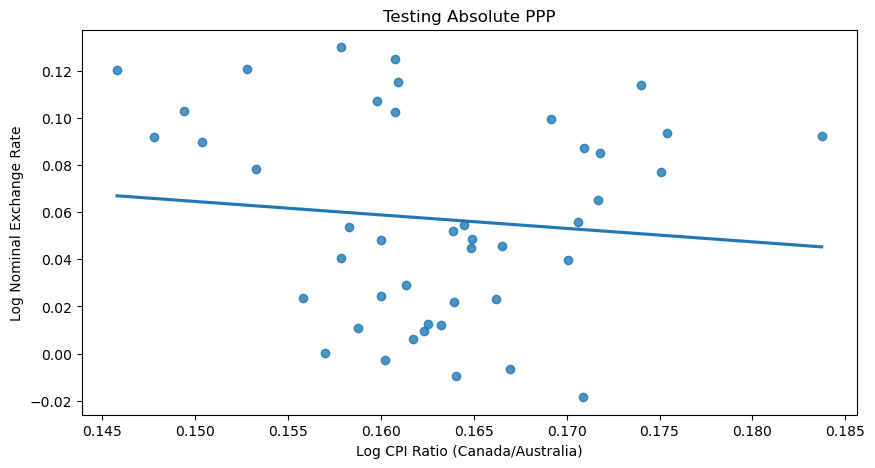

In [22]:
plt.figure(figsize=(10, 5))
sns.regplot(x=forecasting["log_CPI_ratio"], y=forecasting["log_nominal_exchange_rate"], ci=None)
plt.xlabel("Log CPI Ratio (Canada/Australia)")
plt.ylabel("Log Nominal Exchange Rate")
plt.title("Testing Absolute PPP")
plt.show()

# Tast 4: Test for [Relative Purchasing Power Parity] on [Real Exchange Rate]

In [23]:
forecasting["Inflation_Australia"] = np.log(forecasting["CPI_australia"]).diff()
forecasting["Inflation_Canada"] = np.log(forecasting["CPI_Canada"]).diff()

forecasting["Inflation_Diff"] = forecasting["Inflation_Australia"] - forecasting["Inflation_Canada"]

forecasting["Exchange_Rate_Change"] = np.log(forecasting["Nominal exchange rate"]).diff()

forecasting = forecasting.replace([np.inf, -np.inf], np.nan).dropna()

X = sm.add_constant(forecasting["Inflation_Diff"])
y = forecasting["Exchange_Rate_Change"]

model = sm.OLS(y, X).fit()

print("\nOLS Regression Results (Relative PPP Test):")
print(model.summary())


OLS Regression Results (Relative PPP Test):
                             OLS Regression Results                             
Dep. Variable:     Exchange_Rate_Change   R-squared:                       0.008
Model:                              OLS   Adj. R-squared:                 -0.016
Method:                   Least Squares   F-statistic:                    0.3349
Date:                  Sun, 13 Apr 2025   Prob (F-statistic):              0.566
Time:                          09:41:55   Log-Likelihood:                 104.27
No. Observations:                    42   AIC:                            -204.5
Df Residuals:                        40   BIC:                            -201.1
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [24]:
def adf_test(series):
    result = adfuller(series, autolag="AIC")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:", result[4])
    if result[1] < 0.05:
        print("Conclusion: Stationary ✅ (Relative PPP holds)")
    else:
        print("Conclusion: Not Stationary ❌ (Relative PPP does not hold)")

print("Testing Relative PPP (Stationarity of Inflation Differential & Exchange Rate Change):")
adf_test(forecasting["Inflation_Diff"])  # Replace with the correct column name

Testing Relative PPP (Stationarity of Inflation Differential & Exchange Rate Change):
ADF Statistic: -2.8944259281624993
p-value: 0.046000036384619664
Critical Values: {'1%': -3.6327426647230316, '5%': -2.9485102040816327, '10%': -2.6130173469387756}
Conclusion: Stationary ✅ (Relative PPP holds)


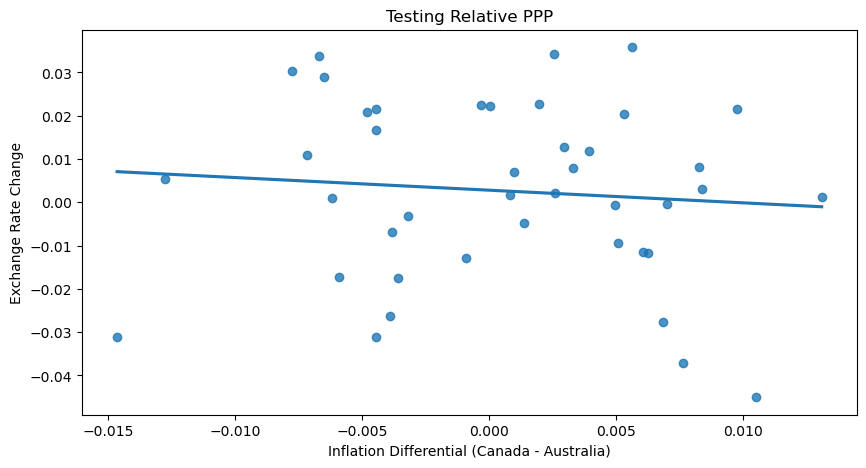

In [25]:
plt.figure(figsize=(10, 5))
sns.regplot(x= forecasting["Inflation_Diff"], y= forecasting["Exchange_Rate_Change"], ci= None)
plt.xlabel("Inflation Differential (Canada - Australia)")
plt.ylabel("Exchange Rate Change")
plt.title("Testing Relative PPP")
plt.show()

In [26]:
# Data for building model

forecasting_diff.head()

,CPI_Canada,CPI_australia,Nominal exchange rate,Real exchange rate,log_nominal_exchange_rate,log_real_exchange_rate,log_CPI_Canada,log_CPI_Australia
Date,,,,,,,,
2014-04-01,1.633333,0.5,-0.031067,-0.033347,-0.031159,-0.039512,0.013086,0.004733
2014-07-01,0.100000,0.5,0.011652,0.013106,0.011801,0.015716,0.000796,0.004710
2014-10-01,-0.466667,0.2,0.036222,0.035541,0.035819,0.041415,-0.003718,0.001878
2015-01-01,0.066667,0.2,-0.004943,-0.003035,-0.004813,-0.003470,0.000532,0.001874
2015-04-01,1.433333,0.7,0.021517,0.014033,0.020784,0.015946,0.011371,0.006533


# Task 5 [Model building]

In [27]:
# Target variable: Real exchange rate

series = forecasting_diff["Real exchange rate"]

In [28]:
# Check the stationarity before implementing the model

def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary. Differencing needed.")

adf_test(series)

ADF Statistic: -6.766240203497674
p-value: 2.7126301324578836e-09
The series is stationary.


# Auto Regressive (AR) model

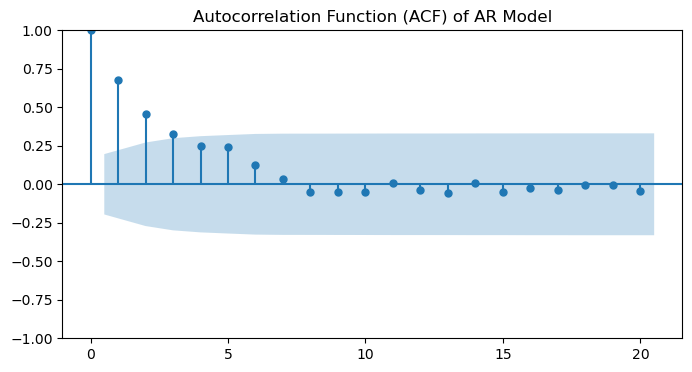

In [29]:
np.random.seed(42)  
ar_params = np.array([0.7])  
ma_params = np.array([0])  
ar = np.r_[1, -ar_params] 
ma = np.r_[1, ma_params]
simulated_data = ArmaProcess(ar, ma).generate_sample(nsample=100)

fig, ax = plt.subplots(figsize=(8, 4))
sm.graphics.tsa.plot_acf(simulated_data, lags=20, ax=ax)
plt.title("Autocorrelation Function (ACF) of AR Model")
plt.show()

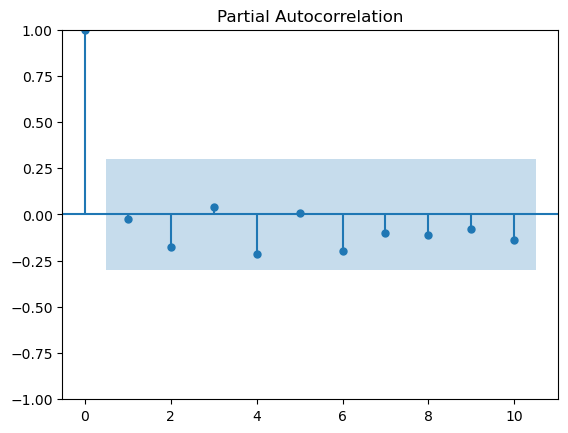

                               SARIMAX Results                                
Dep. Variable:     Real exchange rate   No. Observations:                   43
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 108.797
Date:                Sun, 13 Apr 2025   AIC                           -211.594
Time:                        09:41:55   BIC                           -206.311
Sample:                    04-01-2014   HQIC                          -209.646
                         - 10-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.003      0.641      0.522      -0.004       0.008
ar.L1         -0.0261      0.154     -0.169      0.866      -0.329       0.277
sigma2         0.0004      0.000      3.607      0.0

/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


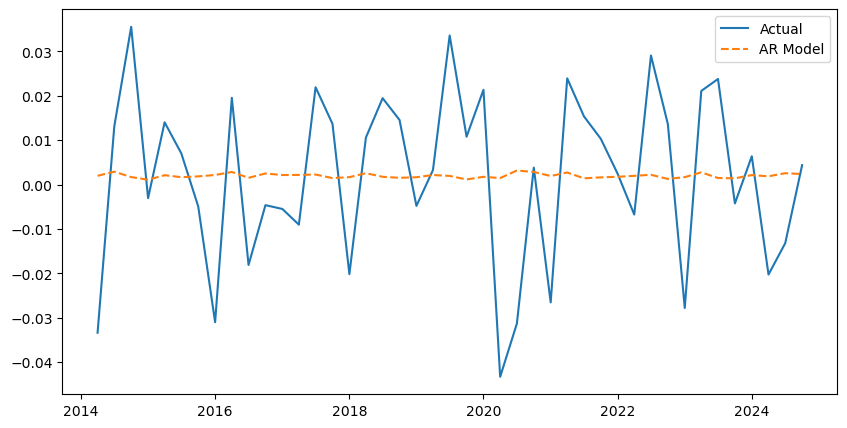

In [30]:
plot_pacf(series, lags= 10)
plt.show()

ar_model = ARIMA(series, order=(1,0,0)).fit()
print(ar_model.summary())

plt.figure(figsize=(10,5))
plt.plot(series, label= "Actual")
plt.plot(ar_model.fittedvalues, label= "AR Model", linestyle= "dashed")
plt.legend()
plt.show()

In [31]:
p = 2

train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

model = ARIMA(train, order=(p, 0, 0)).fit()

forecast = model.forecast(steps=len(test))

mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = mse ** 0.5
mape = (abs(test - forecast) / test).mean() * 100

print(f"MAE: {mae:.6f}")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAPE: {mape:.2f}%")

MAE: 0.014244
MSE: 0.000272
RMSE: 0.016503
MAPE: -13.43%


/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


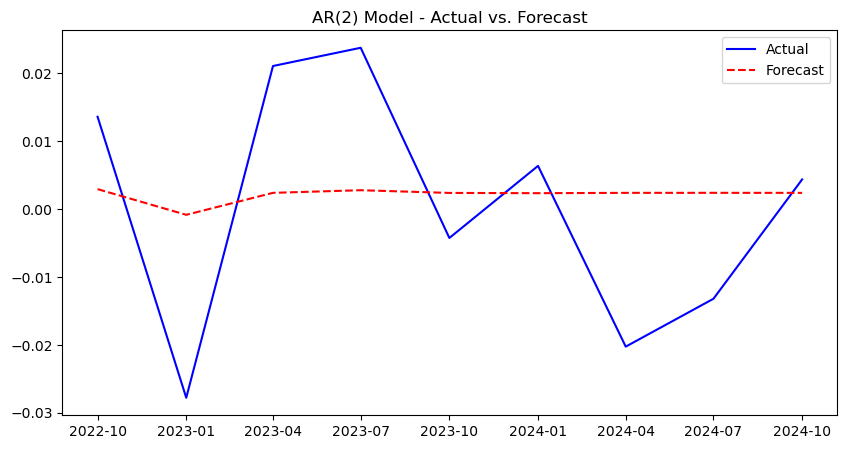

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label="Actual", color="blue")
plt.plot(test.index, forecast, label="Forecast", color="red", linestyle="dashed")
plt.legend()
plt.title(f"AR({p}) Model - Actual vs. Forecast")
plt.show()

# Moving average (MA) model

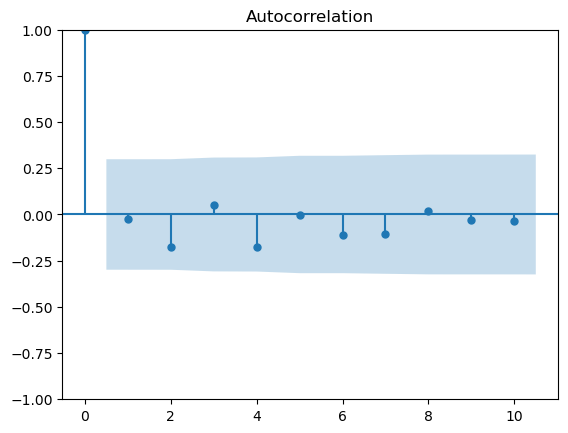

/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:     Real exchange rate   No. Observations:                   43
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 108.806
Date:                Sun, 13 Apr 2025   AIC                           -211.612
Time:                        09:41:55   BIC                           -206.328
Sample:                    04-01-2014   HQIC                          -209.664
                         - 10-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.003      0.658      0.511      -0.004       0.008
ma.L1         -0.0435      0.157     -0.278      0.781      -0.351       0.264
sigma2         0.0004      0.000      3.605      0.0

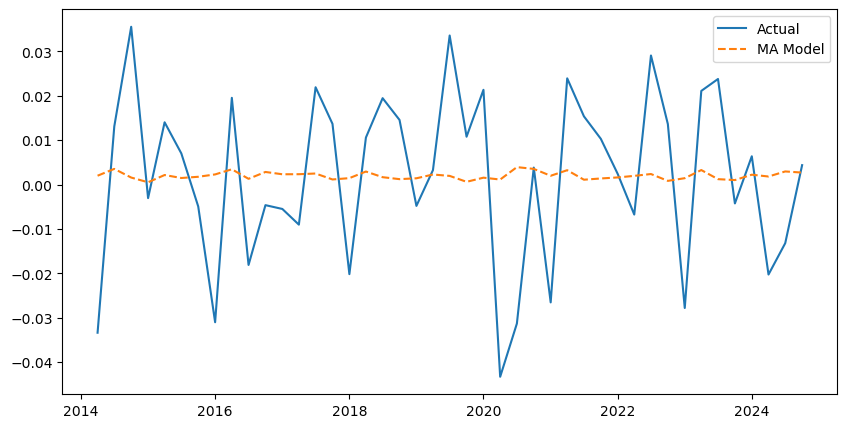

In [33]:
plot_acf(series, lags= 10)
plt.show()

ma_model = ARIMA(series, order=(0,0,1)).fit()
print(ma_model.summary())

plt.figure(figsize=(10,5))
plt.plot(series, label= "Actual")
plt.plot(ma_model.fittedvalues, label= "MA Model", linestyle= "dashed")
plt.legend()
plt.show()

<Figure size 800x500 with 0 Axes>

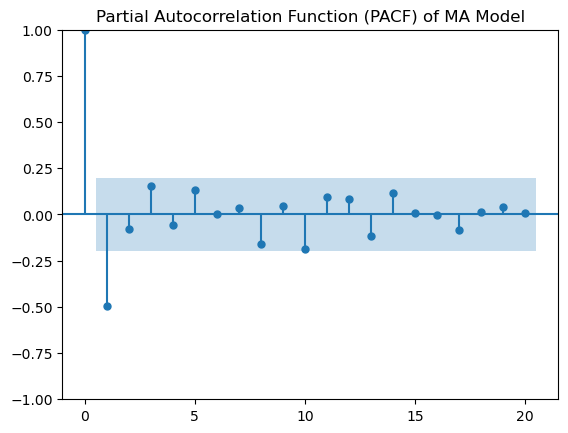

In [34]:
np.random.seed(42)
n = 100
error = np.random.normal(0, 1, n)
ma_process = np.convolve(error, np.array([1, -0.5, 0.3]), mode= 'same') 

plt.figure(figsize=(8,5))
plot_pacf(ma_process, lags= 20, method= 'ywm', alpha= 0.05)
plt.title("Partial Autocorrelation Function (PACF) of MA Model")
plt.show()

In [35]:
q = 2  

train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

model = ARIMA(train, order=(0, 0, q)).fit()

forecast = model.forecast(steps=len(test))

mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100

print(f"MA({q}) Model Evaluation Metrics:")
print(f"MAE: {mae:.6f}")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAPE: {mape:.2f}%")

MA(2) Model Evaluation Metrics:
MAE: 0.013888
MSE: 0.000254
RMSE: 0.015926
MAPE: 92.92%


/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


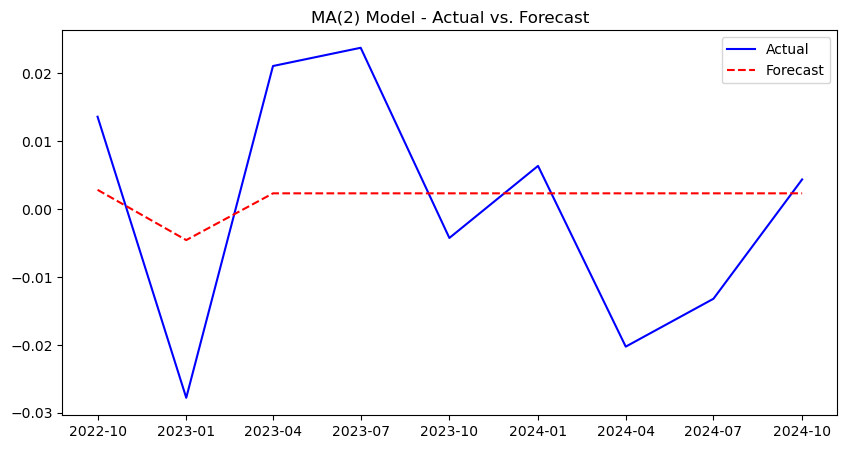

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label= "Actual", color= "blue")
plt.plot(test.index, forecast, label= "Forecast", color= "red", linestyle= "dashed")
plt.legend()
plt.title(f"MA({q}) Model - Actual vs. Forecast")
plt.show()

# Auto Regressive Moving Average (ARMA) model

/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:     Real exchange rate   No. Observations:                   43
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 109.672
Date:                Sun, 13 Apr 2025   AIC                           -211.344
Time:                        09:41:56   BIC                           -204.299
Sample:                    04-01-2014   HQIC                          -208.746
                         - 10-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.004      0.560      0.575      -0.005       0.009
ar.L1         -0.7853      0.202     -3.882      0.000      -1.182      -0.389
ma.L1          0.9151      0.159      5.741      0.0

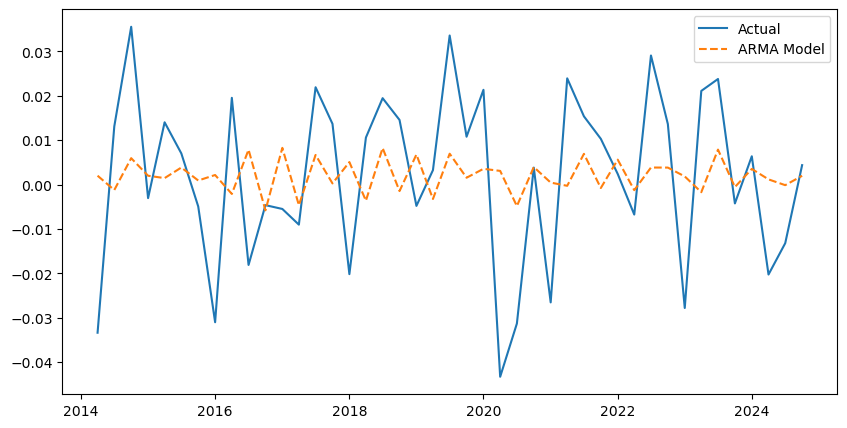

In [37]:
arma_model = ARIMA(series, order=(1,0,1)).fit()
print(arma_model.summary())

plt.figure(figsize=(10,5))
plt.plot(series, label= "Actual")
plt.plot(arma_model.fittedvalues, label= "ARMA Model", linestyle= "dashed")
plt.legend()
plt.show()

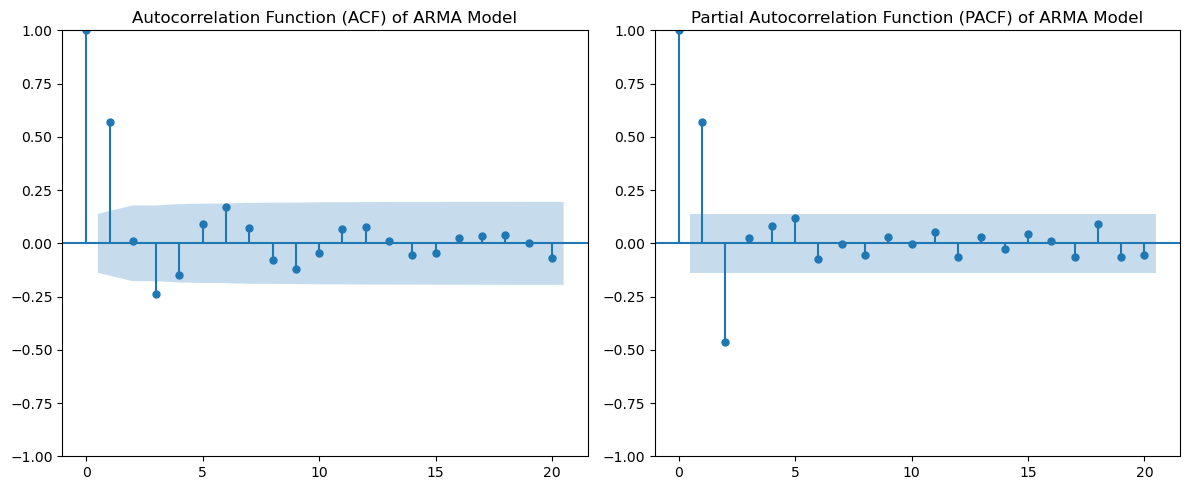

In [38]:
ar_params = np.array([0.5, -0.3]) 
ma_params = np.array([0.4, 0.2])  

arma_process = ArmaProcess(np.r_[1, -ar_params], np.r_[1, ma_params])
np.random.seed(42)
time_series = arma_process.generate_sample(nsample= 200)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sm.graphics.tsa.plot_acf(time_series, lags= 20, ax= axes[0], alpha= 0.05)
axes[0].set_title("Autocorrelation Function (ACF) of ARMA Model")
                  
sm.graphics.tsa.plot_pacf(time_series, lags= 20, ax= axes[1], alpha= 0.05)
axes[1].set_title("Partial Autocorrelation Function (PACF) of ARMA Model")

plt.tight_layout()
plt.show() 

In [39]:
p, q = 2, 2  

train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

model = ARIMA(train, order=(p, 0, q)).fit()

forecast = model.forecast(steps= len(test))

mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100

print(f"ARMA({p},{q}) Model Evaluation Metrics:")
print(f"MAE: {mae:.6f}")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAPE: {mape:.2f}%")

ARMA(2,2) Model Evaluation Metrics:
MAE: 0.015285
MSE: 0.000304
RMSE: 0.017441
MAPE: 100.14%


/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/purandarakashyap/anaconda3/lib/p

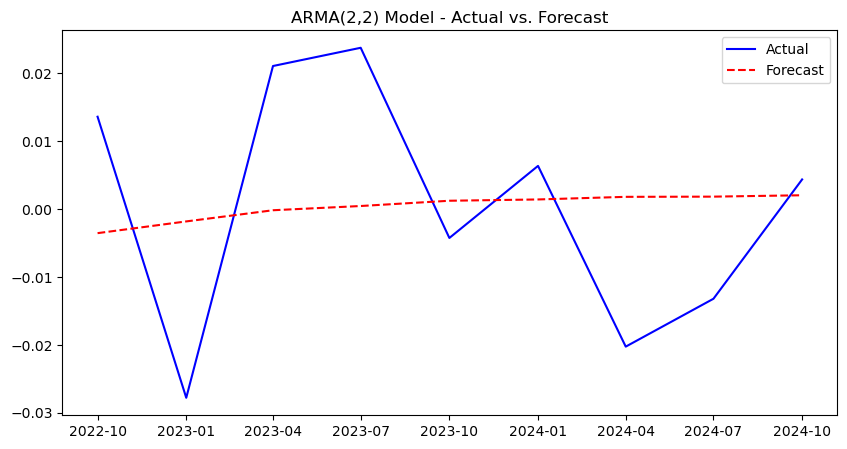

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label= "Actual", color= "blue")
plt.plot(test.index, forecast, label= "Forecast", color= "red", linestyle= "dashed")
plt.legend()
plt.title(f"ARMA({p},{q}) Model - Actual vs. Forecast")
plt.show()

# Auto Regressive Integrated Moving Average (ARIMA) model

In [41]:
def evaluate_forecast(true, pred):
    mae = mean_absolute_error(true, pred)
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((true - pred) / true)) * 100
    return mae, mse, rmse, mape

train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

results = {}

naive_pred = [train.iloc[-1]] * len(test)
results['Naive'] = evaluate_forecast(test, naive_pred)

orders = [(1,1,0), (0,1,1), (1,1,1), (2,1,0), (0,1,2), (2,1,2)]

for order in orders:
    model = ARIMA(train, order= order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    label = f'ARIMA{order}'
    results[label] = evaluate_forecast(test, forecast)

results_df = pd.DataFrame(results, index=['MAE', 'MSE', 'RMSE', 'MAPE']).T
print(results_df.sort_values('RMSE'))

/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/b

                     MAE       MSE      RMSE        MAPE
ARIMA(0, 1, 2)  0.014640  0.000295  0.017174   95.477160
ARIMA(1, 1, 1)  0.014665  0.000296  0.017191   95.652160
ARIMA(0, 1, 1)  0.014691  0.000296  0.017217   95.799872
ARIMA(2, 1, 2)  0.014940  0.000300  0.017317   98.818349
ARIMA(2, 1, 0)  0.016235  0.000399  0.019979  141.374115
ARIMA(1, 1, 0)  0.019448  0.000628  0.025050  185.578454
Naive           0.028653  0.001113  0.033362  294.118391


In [42]:
def adf_test(series):
    result = adfuller(series, autolag="AIC")
    print(f"ADF Statistic: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6f}")
    print("Critical Values:", result[4])
    if result[1] < 0.05:
        print("Conclusion: Stationary ✅")
    else:
        print("Conclusion: Not Stationary ❌ (Differencing needed)")

print("Checking Stationarity:")
adf_test(series)

Checking Stationarity:
ADF Statistic: -6.766240
p-value: 0.000000
Critical Values: {'1%': -3.596635636000432, '5%': -2.933297331821618, '10%': -2.6049909750566895}
Conclusion: Stationary ✅


In [43]:
orders = [(1,1,0), (0,1,1), (1,1,1), (2,1,0), (0,1,2), (2,1,2)]
models = {}

train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

In [44]:
for order in orders:
    try:
        model = ARIMA(train, order=order).fit()
        models[order] = model
        print(f"ARIMA{order} - AIC: {model.aic:.2f}, BIC: {model.bic:.2f}")
    except:
        print(f"ARIMA{order} failed to converge.")

/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/b

ARIMA(1, 1, 0) - AIC: -145.31, BIC: -142.32
ARIMA(0, 1, 1) - AIC: -156.64, BIC: -153.65
ARIMA(1, 1, 1) - AIC: -154.67, BIC: -150.18
ARIMA(2, 1, 0) - AIC: -147.70, BIC: -143.21
ARIMA(0, 1, 2) - AIC: -154.67, BIC: -150.18
ARIMA(2, 1, 2) - AIC: -152.19, BIC: -144.70


/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/purandarakashyap/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/b

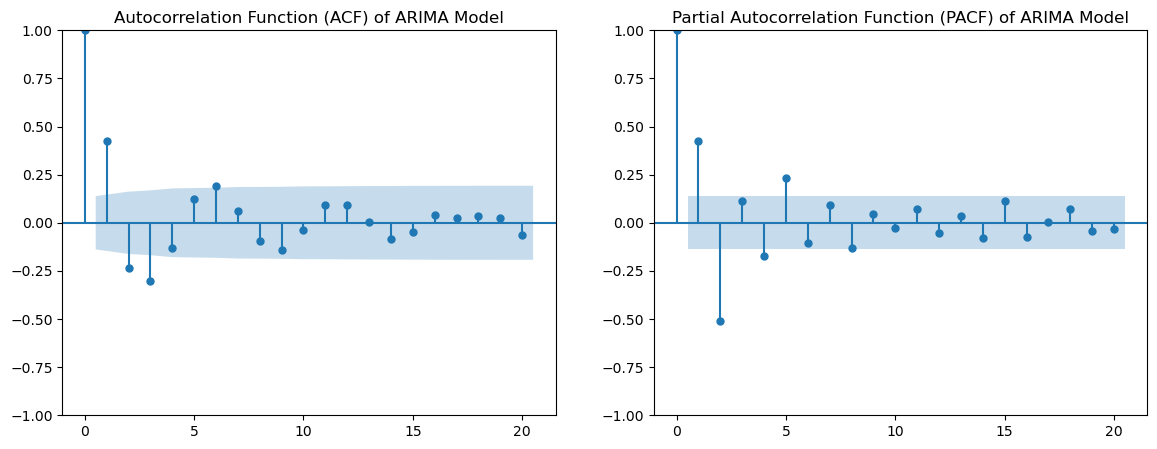

In [45]:
np.random.seed(42)
ar = np.array([1, -0.5, 0.25])  
ma = np.array([1, 0.4, -0.3])   
ARIMA_process = ArmaProcess(ar, ma)
simulated_data = ARIMA_process.generate_sample(nsample=200)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(simulated_data, ax= ax[0], lags= 20)
ax[0].set_title("Autocorrelation Function (ACF) of ARIMA Model")

plot_pacf(simulated_data, ax= ax[1], lags= 20)
ax[1].set_title("Partial Autocorrelation Function (PACF) of ARIMA Model")

plt.show()

In [46]:
best_order = min(models, key= lambda k: models[k].aic)
best_model = models[best_order]
print(f"\nBest ARIMA Model: ARIMA{best_order}")


Best ARIMA Model: ARIMA(0, 1, 1)


In [47]:
print("Best Model Summary:")
print(best_model.summary())

Best Model Summary:
                               SARIMAX Results                                
Dep. Variable:     Real exchange rate   No. Observations:                   34
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  80.322
Date:                Sun, 13 Apr 2025   AIC                           -156.643
Time:                        09:41:57   BIC                           -153.650
Sample:                    04-01-2014   HQIC                          -155.636
                         - 07-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9783      0.455     -2.152      0.031      -1.869      -0.087
sigma2         0.0004      0.000      1.627      0.104   -8.45e-05       0.001
Ljung-Box (L1) (Q):             

In [48]:
forecast = best_model.forecast(steps=len(test))

In [49]:
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100

print("Evaluation Metrics for ARIMA Model:")
print(f"MAE: {mae:.6f}")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAPE: {mape:.2f}%")

summary_data_dispersion = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'MAPE'],
    'Value': [mae, mse, rmse, mape]
})

print("The evaluation metrics on ARIMA model:")
print(tabulate(summary_data_dispersion, headers= 'keys', tablefmt= 'pretty'))

Evaluation Metrics for ARIMA Model:
MAE: 0.014691
MSE: 0.000296
RMSE: 0.017217
MAPE: 95.80%
The evaluation metrics on ARIMA model:
+---+--------+------------------------+
|   | Metric |         Value          |
+---+--------+------------------------+
| 0 |  MAE   |  0.014690577986804355  |
| 1 |  MSE   | 0.00029643307214831247 |
| 2 |  RMSE  |  0.017217231837560663  |
| 3 |  MAPE  |   95.79987197793751    |
+---+--------+------------------------+


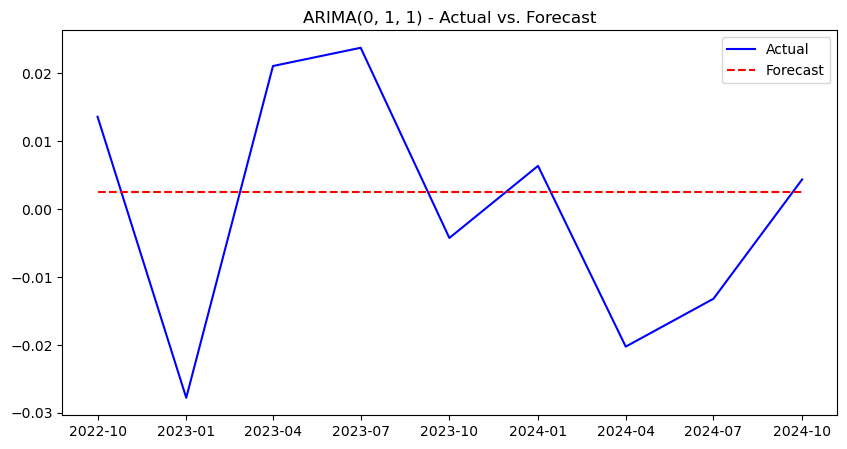

In [50]:
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label= "Actual", color= "blue")
plt.plot(test.index, forecast, label= "Forecast", color= "red", linestyle= "dashed")
plt.legend()
plt.title(f"ARIMA{best_order} - Actual vs. Forecast")
plt.show()

# Graphical representation on model metrics

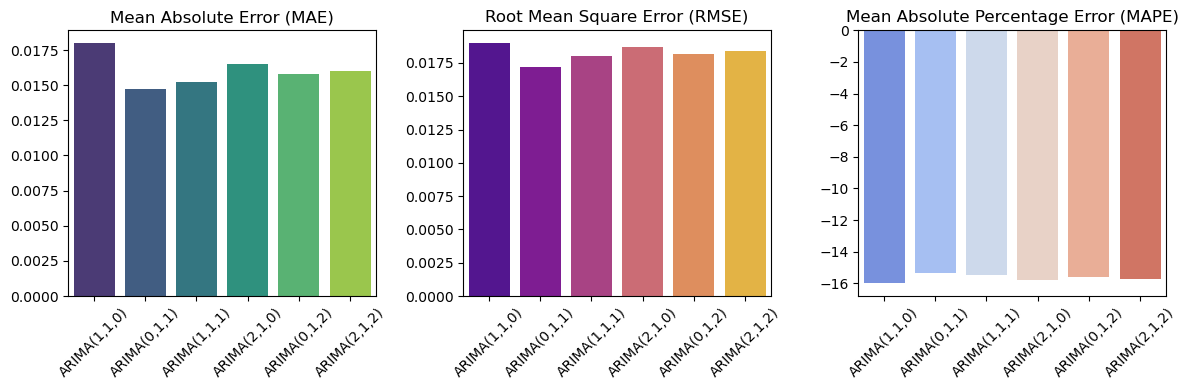

In [51]:
models = ["ARIMA(1,1,0)", "ARIMA(0,1,1)", "ARIMA(1,1,1)", "ARIMA(2,1,0)", "ARIMA(0,1,2)", "ARIMA(2,1,2)"]
mae_values = [0.018, 0.0147, 0.0152, 0.0165, 0.0158, 0.016] 
rmse_values = [0.019, 0.0172, 0.018, 0.0187, 0.0182, 0.0184]
mape_values = [-16, -15.33, -15.5, -15.8, -15.6, -15.7]

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.barplot(x= models, y= mae_values, palette= "viridis")
plt.xticks(rotation= 45)
plt.title("Mean Absolute Error (MAE)")

plt.subplot(1, 3, 2)
sns.barplot(x= models, y= rmse_values, palette= "plasma")
plt.xticks(rotation= 45)
plt.title("Root Mean Square Error (RMSE)")

plt.subplot(1, 3, 3)
sns.barplot(x= models, y= mape_values, palette= "coolwarm")
plt.xticks(rotation= 45)
plt.title("Mean Absolute Percentage Error (MAPE)")

plt.tight_layout()
plt.show()

In [52]:
forecasting.head()

,CPI_Canada,CPI_australia,Nominal exchange rate,Real exchange rate,log_nominal_exchange_rate,log_real_exchange_rate,log_CPI_Canada,log_CPI_Australia,CPI_Canada_diff2,log_CPI_Canada_diff2,log_CPI_ratio,Inflation_Australia,Inflation_Canada,Inflation_Diff,Exchange_Rate_Change
Date,,,,,,,,,,,,,,,
2014-07-01,125.733333,106.4,0.993251,0.840524,-0.006772,-0.173729,4.834163,4.667206,-1.533333,-0.012290,0.166958,0.004710,0.000796,0.003915,0.011801
2014-10-01,125.266667,106.6,1.029473,0.876066,0.029047,-0.132314,4.830445,4.669084,-0.566667,-0.004514,0.161361,0.001878,-0.003718,0.005596,0.035819
2015-01-01,125.333333,106.8,1.024530,0.873031,0.024234,-0.135785,4.830977,4.670958,0.533333,0.004251,0.160019,0.001874,0.000532,0.001342,-0.004813
2015-04-01,126.766667,107.5,1.046047,0.887063,0.045018,-0.119839,4.842348,4.677491,1.366667,0.010839,0.164857,0.006533,0.011371,-0.004838,0.020784
2015-07-01,127.233333,108.0,1.053315,0.894089,0.051942,-0.111949,4.846023,4.682131,-0.966667,-0.007697,0.163891,0.004640,0.003675,0.000966,0.006924


In [55]:
# forecasting.to_csv(r"/Users/purandarakashyap/Documents/UCC/Semester - 2/forecasting.csv")

# Forecasting the future trend

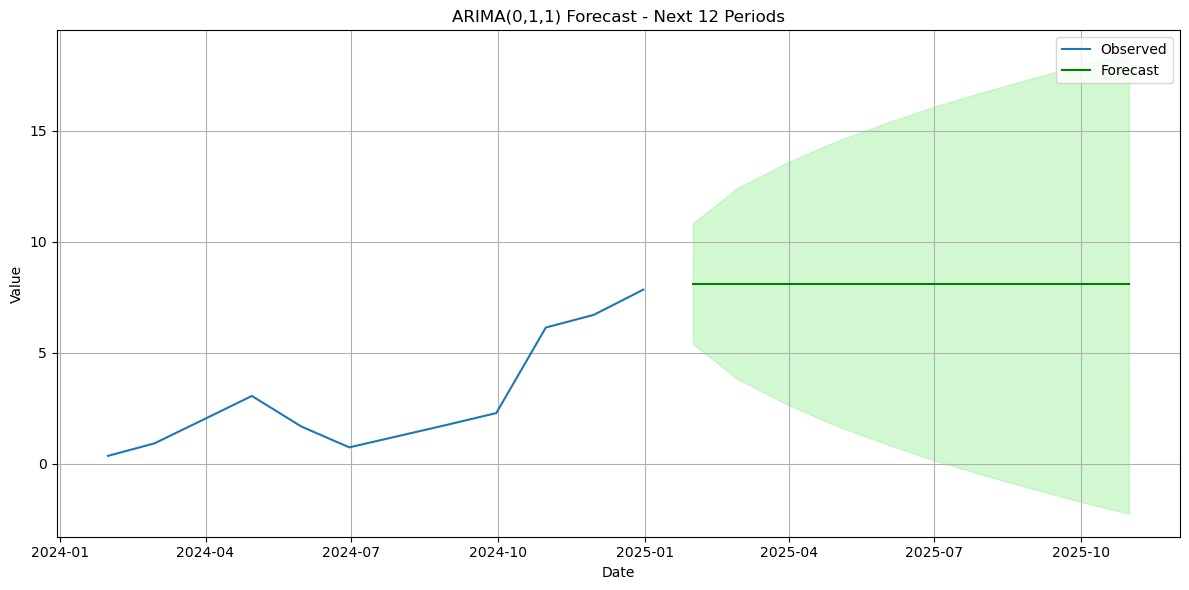

In [56]:
date_range = pd.date_range(start='2024-01-01', periods=12, freq='M')
data = np.random.randn(12).cumsum() 
ts = pd.Series(data, index=date_range)

model = ARIMA(ts, order=(0, 1, 1))
model_fit = model.fit()

forecast = model_fit.get_forecast(steps=10)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='green')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='lightgreen', alpha=0.4)
plt.title('ARIMA(0,1,1) Forecast - Next 12 Periods')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# The end